__Exploratory Data Analysis (EDA)__

- Inspect distributions, missing values, outliers.
- Plot time series of IV, skew, curvature.
- Compare SPY vs QQQ.
- Correlation checks.
- Document findings.

In [1]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

__Load the filtered parquet__

In [2]:
df = pd.read_parquet("options_filtered/", engine="fastparquet")
df.head()

,date,secid,ticker,cp_flag,exdate,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,vega,theta,forward_price,expiry_indicator,dte,symbol,year
0,2023-01-05,107899.0,QQQ,C,2023-02-03,235000.0,28.51,28.76,1.0,0.0,0.327117,0.893171,13.555630,-36.41304,None,w,29,QQQ 230203C235000,2023
1,2023-01-06,107899.0,QQQ,C,2023-02-03,235000.0,34.93,35.14,0.0,1.0,0.314822,0.947135,7.996203,-24.93087,None,w,28,QQQ 230203C235000,2023
2,2023-01-03,107899.0,QQQ,C,2023-02-03,240000.0,27.06,27.26,0.0,4.0,0.329996,0.863050,16.898940,-41.11151,None,w,31,QQQ 230203C240000,2023
3,2023-01-04,107899.0,QQQ,C,2023-02-03,240000.0,27.72,27.95,0.0,4.0,0.312839,0.887761,14.494350,-35.53951,None,w,30,QQQ 230203C240000,2023
4,2023-01-05,107899.0,QQQ,C,2023-02-03,240000.0,24.15,24.31,10.0,4.0,0.317249,0.851751,17.048410,-42.25031,None,w,29,QQQ 230203C240000,2023


__Inspect distributions, missing values, outliers__

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234969 entries, 0 to 234968
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              234969 non-null  datetime64[ns]
 1   secid             234969 non-null  float64       
 2   ticker            234969 non-null  object        
 3   cp_flag           234969 non-null  object        
 4   exdate            234969 non-null  datetime64[ns]
 5   strike_price      234969 non-null  float64       
 6   best_bid          234969 non-null  float64       
 7   best_offer        234969 non-null  float64       
 8   volume            234969 non-null  float64       
 9   open_interest     234969 non-null  float64       
 10  impl_volatility   234969 non-null  float64       
 11  delta             234969 non-null  float64       
 12  vega              234969 non-null  float64       
 13  theta             234969 non-null  float64       
 14  forw

In [4]:
df.isna().sum()

date                     0
secid                    0
ticker                   0
cp_flag                  0
exdate                   0
strike_price             0
best_bid                 0
best_offer               0
volume                   0
open_interest            0
impl_volatility          0
delta                    0
vega                     0
theta                    0
forward_price       234969
expiry_indicator    114000
dte                      0
symbol                   0
year                     0
dtype: int64

In [5]:
# Unique symbols
print(df['ticker'].unique())

# Or with counts
print(df['ticker'].value_counts())

['QQQ' 'SPY']
ticker
QQQ    118970
SPY    115999
Name: count, dtype: int64


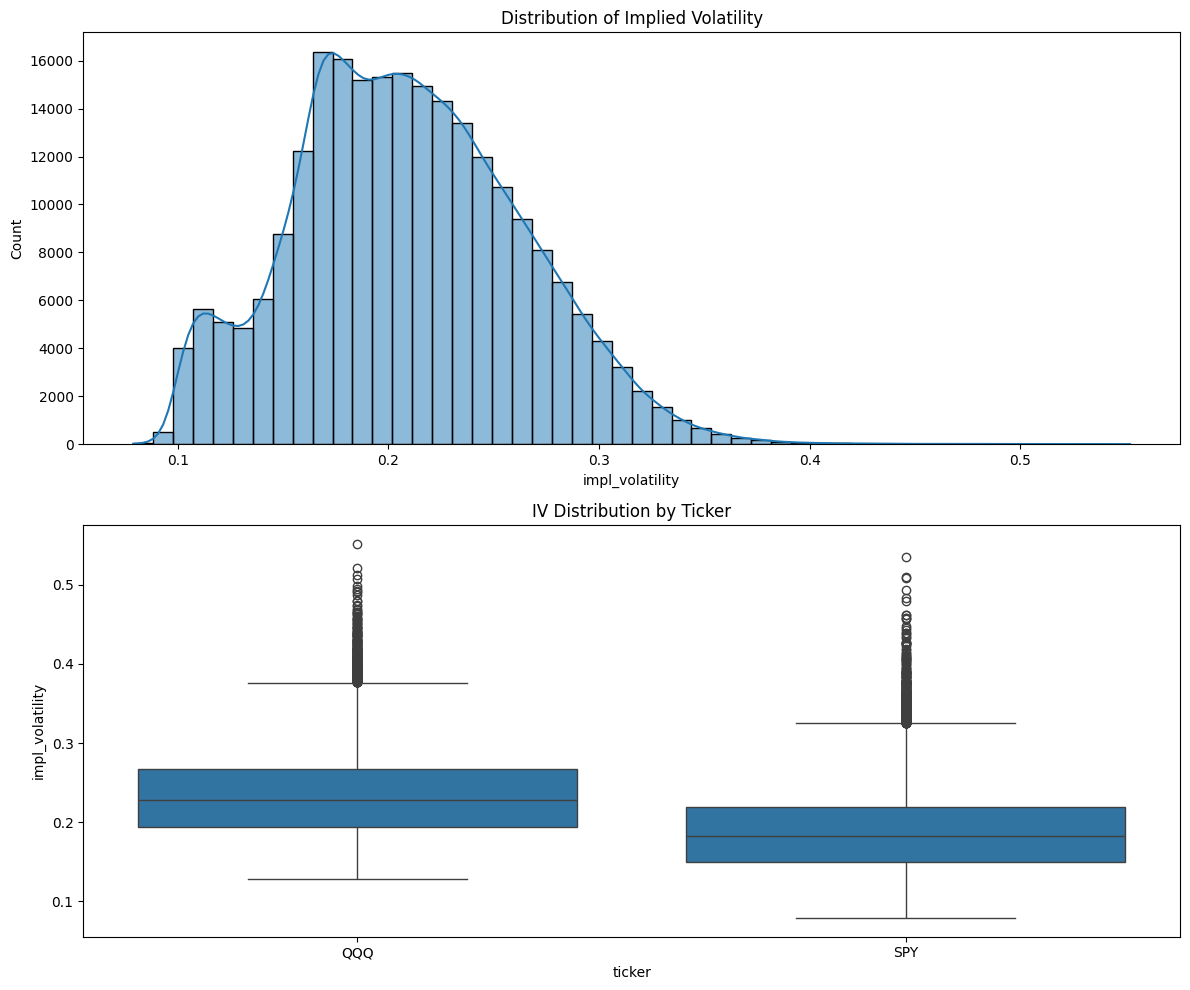

In [6]:
fig, axes = plt.subplots(2,1, figsize=(12,10))

# Distribution of IV
sns.histplot(data=df, x='impl_volatility', bins=50, kde=True, ax = axes[0])
axes[0].set_title("Distribution of Implied Volatility")

# Boxplot by symbol
sns.boxplot(x='ticker', y='impl_volatility', data=df, ax = axes[1])
axes[1].set_title("IV Distribution by Ticker")

plt.tight_layout()
plt.show()

Implied volatility is concentrated between roughly 15% and 30%, with very few outliers above 30%. This suggests the dataset is clean after filtering. SPY and QQQ show broadly similar IV distributions, with QQQ’s median only slightly higher, reflecting modest sector risk differences. Outliers above 0.3 may represent short‑term stress events or occasional bad quotes, but they are rare and do not dominate the distribution.

__Aggregate daily features (ATM IV, skew, curvature)__

In [7]:
features = []

# Group by date and symbol (ticker)
for (date, ticker), group in df.groupby(['date','ticker']):
    group = group.copy()
    
    # --- ATM IV by delta ---
    atm_row = group.iloc[(group['delta'].abs() - 0.5).abs().argsort()[:1]]
    atm_iv = atm_row['impl_volatility'].values[0]

    # --- 25-delta put and call ---
    put25 = group.loc[group['cp_flag'] == 'P']
    call25 = group.loc[group['cp_flag'] == 'C']

    if not put25.empty and not call25.empty:
        put25_idx = (put25['delta'] + 0.25).abs().idxmin()
        call25_idx = (call25['delta'] - 0.25).abs().idxmin()

        iv_put25 = group.loc[put25_idx, 'impl_volatility']
        iv_call25 = group.loc[call25_idx, 'impl_volatility']

        skew = iv_put25 - iv_call25
        curvature = (iv_put25 + iv_call25) / 2 - atm_iv
    else:
        skew = curvature = np.nan

    features.append({
        'date': date,
        'ticker': ticker,
        'ATM_IV': atm_iv,
        'Skew': skew,
        'Curvature': curvature
    })

features_df = pd.DataFrame(features)
features_df.head()

,date,ticker,ATM_IV,Skew,Curvature
0,2023-01-03,QQQ,0.282223,0.047618,-0.000384
1,2023-01-03,SPY,0.218996,0.040678,-0.001558
2,2023-01-04,QQQ,0.274456,0.061536,-0.001318
3,2023-01-04,SPY,0.208724,0.049671,0.003933
4,2023-01-05,QQQ,0.282380,0.038932,-0.006200


Pull in the TBills Secondary Market 3-month (dtb3) and Treasury Constant Maturity 2-year (dgs2) from WRDS FRB and join by date

In [8]:
db = wrds.Connection(wrds_username='ayansola')
# setup pg_pass needed for access to the wrds dataset (first time only)
# db.create_pgpass_file()

Loading library list...
Done


In [9]:
params = {
    "from_date": "2022-01-01",
    "to_date": "2023-12-31"
}

t_bill = db.raw_sql(
    """
    SELECT date, dtb3 as tbills_3m, dgs2 as treasury_2y
    FROM frb.rates_daily
    WHERE date BETWEEN %(from_date)s AND %(to_date)s
    """,
    params=params,
)

In [10]:
t_bill.dtypes

date           string[python]
tbills_3m             Float64
treasury_2y           Float64
dtype: object

In [11]:
t_bill['date'] = pd.to_datetime(t_bill['date'])

In [12]:
t_bill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         730 non-null    datetime64[ns]
 1   tbills_3m    499 non-null    Float64       
 2   treasury_2y  499 non-null    Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 18.7 KB


In [13]:
t_bill.head()

,date,tbills_3m,treasury_2y
0,2022-01-01,<NA>,<NA>
1,2022-01-02,<NA>,<NA>
2,2022-01-03,0.09,0.78
3,2022-01-04,0.08,0.77
4,2022-01-05,0.09,0.83


In [14]:
features_df = features_df.merge(t_bill[['date','tbills_3m', 'treasury_2y']], on='date', how='left')

In [15]:
features_df.head()

,date,ticker,ATM_IV,Skew,Curvature,tbills_3m,treasury_2y
0,2023-01-03,QQQ,0.282223,0.047618,-0.000384,4.4,4.4
1,2023-01-03,SPY,0.218996,0.040678,-0.001558,4.4,4.4
2,2023-01-04,QQQ,0.274456,0.061536,-0.001318,4.41,4.36
3,2023-01-04,SPY,0.208724,0.049671,0.003933,4.41,4.36
4,2023-01-05,QQQ,0.282380,0.038932,-0.006200,4.51,4.45


__Plot time series of IV, skew, curvature & compare SPY vs QQQ__

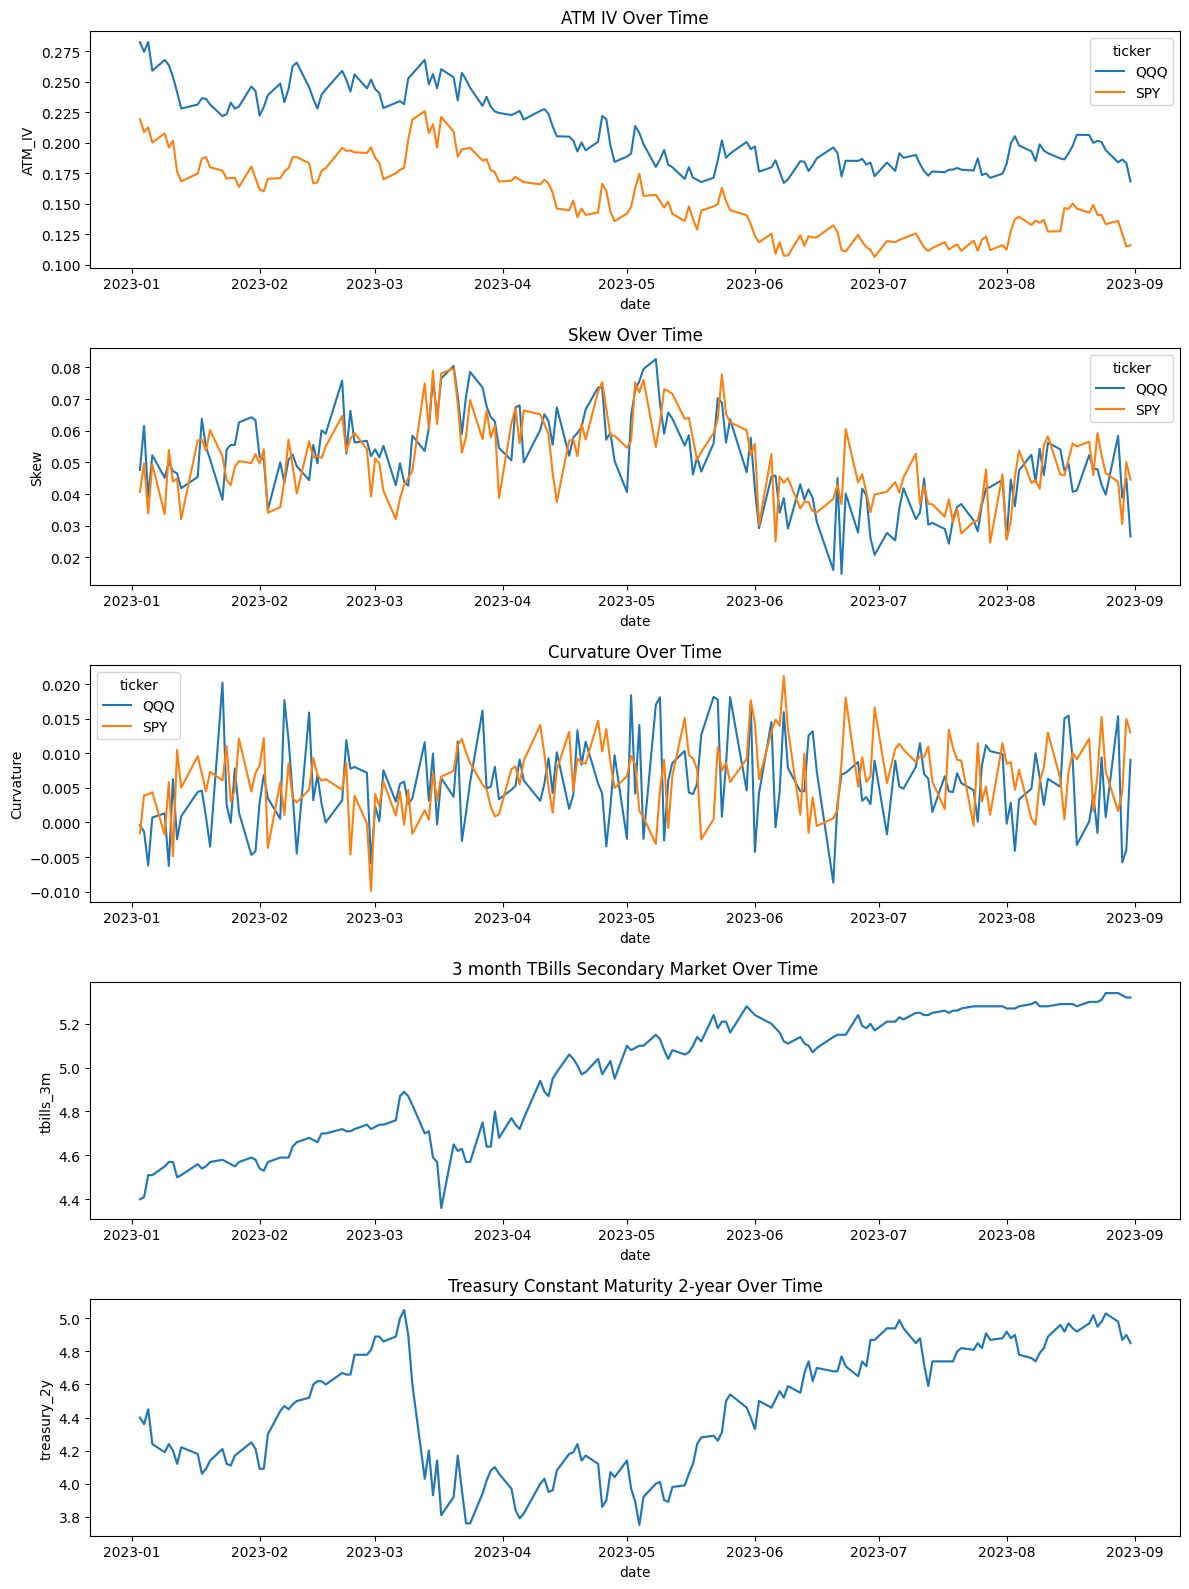

In [16]:
fig, axes = plt.subplots(5,1, figsize=(12,16))

sns.lineplot(data=features_df, x='date', y='ATM_IV', hue='ticker', ax = axes[0])
axes[0].set_title("ATM IV Over Time")

sns.lineplot(data=features_df, x='date', y='Skew', hue='ticker', ax = axes[1])
axes[1].set_title("Skew Over Time")

sns.lineplot(data=features_df, x='date', y='Curvature', hue='ticker', ax = axes[2])
axes[2].set_title("Curvature Over Time")

sns.lineplot(data=features_df, x='date', y='tbills_3m', ax = axes[3])
axes[3].set_title("3 month TBills Secondary Market Over Time")

sns.lineplot(data=features_df, x='date', y='treasury_2y', ax = axes[4])
axes[4].set_title("Treasury Constant Maturity 2-year Over Time")


# sns.lineplot(data=features_df, x='date', y='dtb1yr', ax = axes[3])
# axes[6].set_title("1 year TBills Secondary Market Over Time")

plt.tight_layout()
plt.show()

- Both symbols experience occasional, brief volatility spikes, with QQQ’s being more pronounced.

- QQQ’s skew is more volatile and often higher, pointing to increased demand for put options

- Curvature is persistently positive for both

- Implied volatility doesn’t track with short‑term rates like the 3‑month bill, but it does respond more visibly to shifts in the 2‑year yield as seen above

In [17]:
# drop dtb3 since IV doesn't track with it
features_df = features_df.drop(columns=['tbills_3m'])

__Correlation checks__

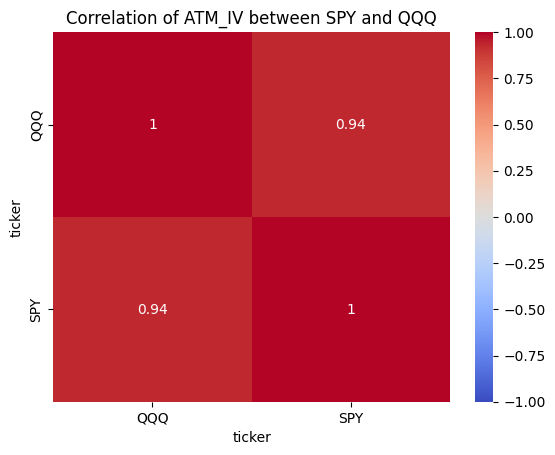

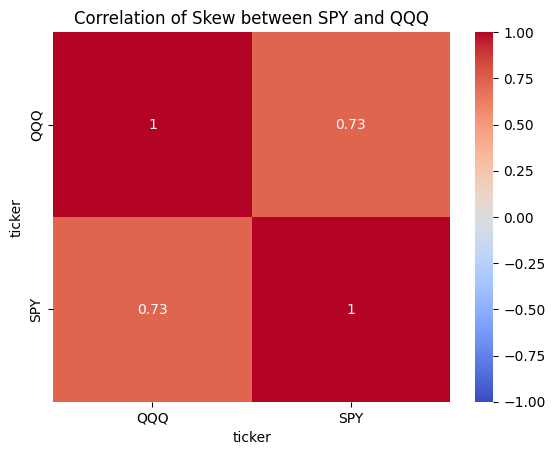

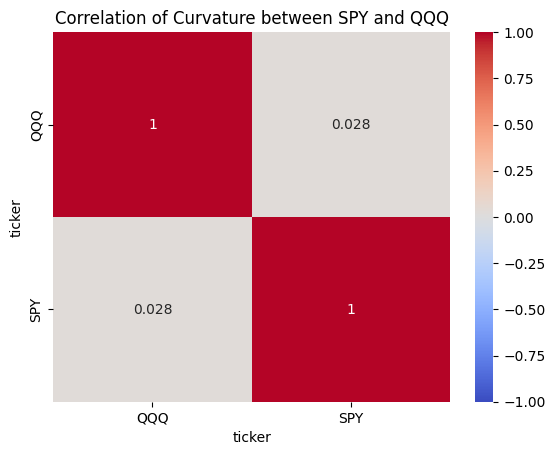

In [18]:
metrics = ['ATM_IV', 'Skew', 'Curvature']

for metric in metrics:
    pivot = features_df.pivot(index='date', columns='ticker', values=metric)
    corr = pivot.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation of {metric} between SPY and QQQ")
    plt.show()

Volatility levels between SPY and QQQ are highly synchronized, skew is moderately aligned but allows for divergence, and curvature behaves almost independently.

In [19]:
series = features_df[features_df['ticker']=='SPY']['ATM_IV']
result = adfuller(series.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.0787661382345597
p-value: 0.723465022438556


### EDA Summary
- **Data quality:** No major missing values.
- **Distributions:** SPY && QQQ IV show broadly similar distributions with SPY IV centered lower than QQQ
- **Time series:** Both symbols show volatility spikes around market stress dates.
- **Correlations:** ATM IV highly correlated (SPY vs QQQ ~0.8).

__Save Aggregate daily features to Parquet: partition by symbol/year for downstream use.__

In [20]:
features_df['year'] = pd.to_datetime(features_df['date']).dt.year

# Write to Parquet with partitioning
features_df.to_parquet(
    "features_parquet/",
    engine="fastparquet",        # or "pyarrow"
    partition_cols=["ticker", "year"],
    index=False
)